In [ ]:
import pandas
import neattext as nt
from datasets import load_dataset
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk import PorterStemmer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

In [ ]:
emotions_dictionary = {'sadness': 0, 'joy': 1, 'anger': 3, 'fear': 4, 'surprise': 5} 

## First dataset: https://huggingface.co/datasets/dair-ai/emotion

In [ ]:
dataset = load_dataset('emotion')
dataset.set_format(type="pandas")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train_df = dataset['train'][:]
valid_df = dataset['validation'][:]
test_df  = dataset['test'][:]

In [ ]:
joint_dataset = pandas.concat([train_df, valid_df, test_df])

In [ ]:
train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
joint_dataset = joint_dataset[joint_dataset['label'] != 2]

In [ ]:
joint_dataset['label'].value_counts()

1    6761
0    5797
3    2709
4    2373
5     719
Name: label, dtype: int64

# Second dataset: google dataset

In [ ]:
second_dataset = pandas.read_csv('google_dataset.csv')
second_dataset = second_dataset[second_dataset['example_very_unclear'] == False]

In [ ]:
# Not let's resize the number of columns in the dataset. We only need 'text', 'label'. Before doin that, we first have
# to assign an emotion to each tweet seeing which bit is set to '1' in the related column. Let's define a function that 
# is able to manage this problem:

FULL_LIST_OF_EMOTIONS = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
                'confusion', 'curiosity', 'desire','disappointment', 'disapproval', 'disgust',
                'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love',
                'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness',
                'surprise','neutral'
               ]

def get_emotion_description_from_row(list_of_bits) -> str:
    """
    Assigns an emotion to each tweet contained into the dataset. 
    
    Accepts:
        The list of bits that represents the emotion assigned to a text
    
    Returns:
        The string that represents emotion assigned to the text taken as input.
    """
    position_of_first_one =  list_of_bits.values.tolist().index(1)
    return FULL_LIST_OF_EMOTIONS[position_of_first_one]
    
    
# Assign emotion to each row
second_dataset['label'] = second_dataset.apply(lambda row: get_emotion_description_from_row(row[FULL_LIST_OF_EMOTIONS]) ,axis=1)

In [ ]:
second_dataset['label'].value_counts()

neutral           55207
admiration        17129
approval          15520
annoyance         11925
disapproval        8909
amusement          8858
gratitude          8432
anger              7943
curiosity          7703
disappointment     6768
confusion          6599
love               5306
caring             5146
realization        5123
joy                5118
optimism           4992
excitement         4374
sadness            3859
surprise           3471
disgust            3419
desire             2999
fear               2510
embarrassment      1720
remorse            1648
nervousness         945
relief              812
pride               714
grief               494
Name: label, dtype: int64

In [ ]:
LIST_OF_EMOTIONS_TO_KEEP = ['joy', 'anger', 'fear', 'sadness','surprise']

second_dataset = second_dataset[second_dataset["label"].isin(LIST_OF_EMOTIONS_TO_KEEP)]


In [ ]:
# Now let's keep only the columns we are intrested in 
second_dataset = second_dataset.filter(items=['text', 'label'])
second_dataset.head(3)

,text,label
0,That game hurt.,sadness
43,By far the coolest thing I've seen on this thr...,joy
49,Sending love and strength vibes <3,joy


<Axes: >

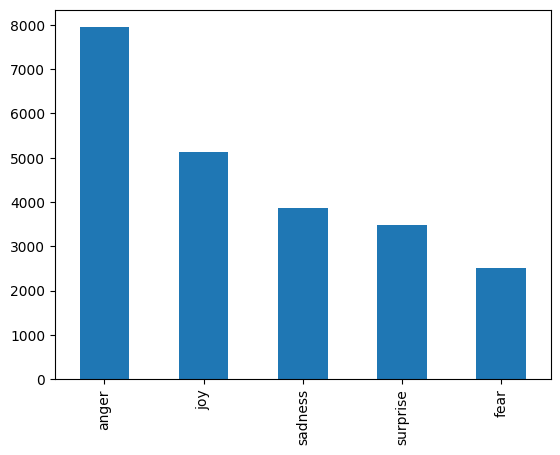

In [ ]:
second_dataset["label"].value_counts().plot(kind='bar')

In [ ]:
second_dataset['label'].value_counts()

anger       7943
joy         5118
sadness     3859
surprise    3471
fear        2510
Name: label, dtype: int64

In [ ]:
second_dataset['label'] = second_dataset['label'].replace(regex='sadness', value=0)
second_dataset['label'] = second_dataset['label'].replace(regex='joy', value=1)
second_dataset['label'] = second_dataset['label'].replace(regex='anger', value=3)
second_dataset['label'] = second_dataset['label'].replace(regex='fear', value=4)
second_dataset['label'] = second_dataset['label'].replace(regex='surprise', value=5)

In [ ]:
second_dataset.head(5)

,text,label
0,That game hurt.,0
43,By far the coolest thing I've seen on this thr...,1
49,Sending love and strength vibes <3,1
58,Me too! First time in a couple of years!,1
60,Ironic. He could save others from secrecy-enab...,5


# Join datasets

In [ ]:
final_dataset = pandas.concat([joint_dataset, second_dataset], axis=0)

In [ ]:
final_dataset['label'].value_counts()

1    11879
3    10652
0     9656
4     4883
5     4190
Name: label, dtype: int64

In [ ]:
train_df, valid_df, test_df = np.split(
    final_dataset.sample(frac=1, random_state=42), 
    [int(.8*len(final_dataset)), int(.9*len(final_dataset))])

In [ ]:
train_df['label'].value_counts()

1    9520
3    8485
0    7705
4    3942
5    3356
Name: label, dtype: int64

In [ ]:
valid_df['label'].value_counts()

1    1186
3    1053
0     990
4     469
5     428
Name: label, dtype: int64

In [ ]:
test_df['label'].value_counts()

1    1173
3    1114
0     961
4     472
5     406
Name: label, dtype: int64

# Undersampling

<Axes: >

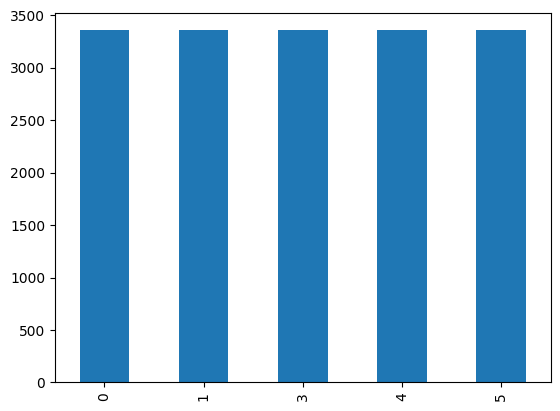

In [ ]:
train_df = train_df.groupby('label').apply(lambda x: x.sample(n=min(3356, len(x))))
train_df['label'].value_counts().plot(kind='bar')

In [ ]:
train_df['label'].value_counts()

0    3356
1    3356
3    3356
4    3356
5    3356
Name: label, dtype: int64

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter=500),
    SGDClassifier()
]

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,1))

X = train_df['text'].values
y = train_df['label'].values

X = tfidf.fit_transform(X)

In [ ]:
CV = 5
cv_df = pandas.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X,  y, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

In [ ]:
cv_df = pandas.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.569726
1,RandomForestClassifier,1,0.600417
2,RandomForestClassifier,2,0.578665
3,RandomForestClassifier,3,0.592968
4,RandomForestClassifier,4,0.589392
5,LinearSVC,0,0.745530
6,LinearSVC,1,0.743743
7,LinearSVC,2,0.736889
8,LinearSVC,3,0.738379
9,LinearSVC,4,0.755066


In [ ]:
cv_df.groupby('model_name').mean()

,fold_idx,accuracy
model_name,,
LinearSVC,2.0,0.743921
LogisticRegression,2.0,0.727652
MultinomialNB,2.0,0.706973
RandomForestClassifier,2.0,0.586234
SGDClassifier,2.0,0.757449


In [ ]:
pipeline = Pipeline([
           ('tfidf', tfidf),
           ('clf', models[4])
            ])

In [ ]:
parameters = { 
    'clf__loss': ['hinge', 'modified_huber', 'squared_hinge', 'perceptron'],
    'clf__max_iter': range(500, 5000)
}

random_estimator = RandomizedSearchCV(pipeline,
                                   param_distributions = parameters,
                                   n_iter = 100,
                                   scoring = 'accuracy',
                                   n_jobs = -1,
                                   verbose = 1, 
                                   random_state = 1,
                                  )


random_estimator.fit(valid_df['text'], valid_df['label'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('clf', SGDClassifier())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'clf__loss': ['hinge', 'modified_huber',
                                                      'squared_hinge',
                                                      'perceptron'],
                                        'clf__max_iter': range(500, 5000)},
                   random_state=1, scoring='accuracy', verbose=1)

In [ ]:
random_estimator.best_params_

{'clf__max_iter': 1837, 'clf__loss': 'hinge'}

In [ ]:
best_estimator = random_estimator.best_estimator_

In [ ]:
X_test = test_df['text']
Y_test = test_df['label']

y_pred_for_nv = best_estimator.predict(X_test)
print('accuracy %s' % accuracy_score(Y_test, y_pred_for_nv))
print(classification_report(Y_test, y_pred_for_nv))

accuracy 0.6982549684924867
              precision    recall  f1-score   support

           0       0.70      0.71      0.71       961
           1       0.77      0.80      0.78      1173
           3       0.67      0.71      0.69      1114
           4       0.67      0.54      0.59       472
           5       0.60      0.52      0.56       406

    accuracy                           0.70      4126
   macro avg       0.68      0.66      0.67      4126
weighted avg       0.70      0.70      0.70      4126



In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
  plt.title("SGDClassifier")
  plt.show()

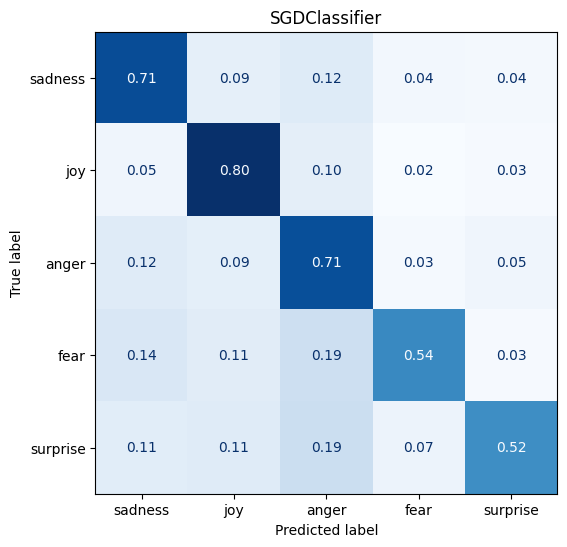

In [ ]:
plot_confusion_matrix(y_pred_for_nv,Y_test,labels=list(emotions_dictionary.keys()))


In [ ]:
labels = test_df['label'].unique().tolist()
labels

[1, 4, 3, 0, 5]

In [ ]:
feature_names = best_estimator.named_steps['tfidf'].get_feature_names_out()

array(['00', '000', '09', ..., 'zooming', 'zum', 'zzzzzzz'], dtype=object)

In [ ]:
eli5.show_weights(best_estimator.named_steps['clf'], feature_names = feature_names, target_names= labels, top=20)